In [56]:
%pip install pmdarima


Note: you may need to restart the kernel to use updated packages.


In [57]:
import math
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings

warnings.filterwarnings('ignore')

In [58]:
#Defining the list of stock tickers
tickers = ["AMZN", "AAPL", "MSFT", "META", "GOOGL"]

#Definng the start and end dates
start_date = dt.datetime.now() - dt.timedelta(days = 6*365)
end_date = dt.datetime.now()

#Here we will fetch the data from yfinance and store it in a dictionary

stock_data = {}
for ticker in tickers:
    stock = yf.Ticker(ticker)
    stock_data[ticker] = stock.history(start = start_date, end = end_date).dropna()

#Concatenate the stock data obtained into one dataframe
data = pd.concat(stock_data.values(), axis =1, keys= stock_data.keys())

data.index = pd.to_datetime(data.index)
print(data.head())
data.describe()

                                AMZN                                   \
                                Open       High        Low      Close   
Date                                                                    
2017-04-05 00:00:00-04:00  45.541000  46.186001  45.280998  45.464001   
2017-04-06 00:00:00-04:00  45.689999  45.859501  44.724499  44.914001   
2017-04-07 00:00:00-04:00  44.982498  45.004501  44.465500  44.743999   
2017-04-10 00:00:00-04:00  44.981499  45.425499  44.950001  45.352001   
2017-04-11 00:00:00-04:00  45.352001  45.562000  44.875000  45.118000   

                                                                  AAPL  \
                              Volume Dividends Stock Splits       Open   
Date                                                                     
2017-04-05 00:00:00-04:00  150168000       0.0          0.0  33.836714   
2017-04-06 00:00:00-04:00  126882000       0.0          0.0  33.853137   
2017-04-07 00:00:00-04:00   74218000       0.

AMZN                                                       \
              Open         High          Low        Close        Volume   
count  1510.000000  1510.000000  1510.000000  1510.000000  1.510000e+03   
mean    110.334371   111.642764   108.878085   110.275193  8.389452e+07   
std      39.847782    40.338291    39.305568    39.787590  3.997408e+07   
min      44.375000    44.748501    44.224499    44.233501  3.920947e+06   
25%      83.940872    84.996252    82.947500    83.743498  5.743078e+07   
50%      96.756752    97.800003    95.500000    96.754002  7.218800e+07   
75%     154.893372   156.630627   151.851498   154.471001  9.870100e+07   
max     187.199997   188.654007   184.839493   186.570496  3.313000e+08   

                                     AAPL                            ...  \
      Dividends Stock Splits         Open         High          Low  ...   
count    1510.0  1510.000000  1510.000000  1510.000000  1510.000000  ...   
mean        0.0     0.013245    91.380382    92.474018    90.352503  ...   
std         0.0     0.514685    48.339102    48.990849    47.721874  ...   
min         0.0     0.000000    33.132855    33.287706    32.860708  ...   
25%         0.0     0.000000    44.730669    45.037678    44.357998  ...   
50%         0.0     0.000000    75.889952    76.908483    75.130634  ...   
75%         0.0     0.000000   140.992229   142.639792   138.628915  ...   
max         0.0    20.000000   181.299361   181.607100   177.814925  ...   

               META                               GOOGL               \
             Volume Dividends Stock Splits         Open         High   
count  1.510000e+03    1510.0       1510.0  1510.000000  1510.000000   
mean   2.350878e+07       0.0          0.0    81.537061    82.437523   
std    1.634815e+07       0.0          0.0    30.802955    31.147873   
min    2.186252e+06       0.0          0.0    41.923000    42.186001   
25%    1.447355e+07       0.0          0.0    55.891001    56.455251   
50%    1.936250e+07       0.0          0.0    69.864002    70.746498   
75%    2.743588e+07       0.0          0.0   104.253248   105.653873   
max    2.323166e+08       0.0          0.0   151.250000   151.546494   

                                                                      
               Low        Close        Volume Dividends Stock Splits  
count  1510.000000  1510.000000  1.510000e+03    1510.0  1510.000000  
mean     80.653168    81.568638  3.511806e+07       0.0     0.013245  
std      30.420133    30.780678  1.591347e+07       0.0     0.514685  
min      41.730000    41.993999  3.009232e+06       0.0     0.000000  
25%      55.331251    55.841375  2.515100e+07       0.0     0.000000  
50%      69.155502    69.992752  3.112345e+07       0.0     0.000000  
75%     103.289377   104.749878  4.006150e+07       0.0     0.000000  
max     148.899002   149.838501  1.331780e+08       0.0    20.000000  

[8 rows x 35 columns]

In [59]:
print(data.columns)

MultiIndex([( 'AMZN',         'Open'),
            ( 'AMZN',         'High'),
            ( 'AMZN',          'Low'),
            ( 'AMZN',        'Close'),
            ( 'AMZN',       'Volume'),
            ( 'AMZN',    'Dividends'),
            ( 'AMZN', 'Stock Splits'),
            ( 'AAPL',         'Open'),
            ( 'AAPL',         'High'),
            ( 'AAPL',          'Low'),
            ( 'AAPL',        'Close'),
            ( 'AAPL',       'Volume'),
            ( 'AAPL',    'Dividends'),
            ( 'AAPL', 'Stock Splits'),
            ( 'MSFT',         'Open'),
            ( 'MSFT',         'High'),
            ( 'MSFT',          'Low'),
            ( 'MSFT',        'Close'),
            ( 'MSFT',       'Volume'),
            ( 'MSFT',    'Dividends'),
            ( 'MSFT', 'Stock Splits'),
            ( 'META',         'Open'),
            ( 'META',         'High'),
            ( 'META',          'Low'),
            ( 'META',        'Close'),
            ( 'META',    

In [60]:
def Test_Stationarity(ticker, data):
    timeseries = data.loc[:, (ticker, 'Close')]
    result = adfuller(timeseries, autolag='AIC')
    print(f"Results of Dickey Fuller Test for {ticker}")
    print(f'Test Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Number of lags used: {result[2]}')
    print(f'Number of observations used: {result[3]}')
    for key, value in result[4].items():
        print(f'critical value ({key}): {value}')
    print("\n")

# Test stationarity for each ticker
for ticker in tickers:
    Test_Stationarity(ticker, data)


Results of Dickey Fuller Test for AMZN
Test Statistics: -1.7729349965692558
p-value: 0.3939790674929876
Number of lags used: 0
Number of observations used: 1509
critical value (1%): -3.434690926976026
critical value (5%): -2.863457245470903
critical value (10%): -2.5677907166982643


Results of Dickey Fuller Test for AAPL
Test Statistics: -0.5184256163371138
p-value: 0.8883704304407171
Number of lags used: 11
Number of observations used: 1498
critical value (1%): -3.4347228578139943
critical value (5%): -2.863471337969528
critical value (10%): -2.5677982210726897


Results of Dickey Fuller Test for MSFT
Test Statistics: -0.8564690553221199
p-value: 0.8019697178260694
Number of lags used: 9
Number of observations used: 1500
critical value (1%): -3.4347170173134813
critical value (5%): -2.8634687603081486
critical value (10%): -2.5677968484444444


Results of Dickey Fuller Test for META
Test Statistics: -1.7181763950250062
p-value: 0.42177262013944916
Number of lags used: 3
Number of obs

In [61]:
 # Calculate log of the 'Close' price for each ticker
for ticker in tickers:
    data.loc[:, (ticker, 'log Close')] = np.log(data.loc[:, (ticker, 'Close')])

# Calculate the rolling mean and standard deviation of the log 'Close' price for each ticker
for ticker in tickers:
    data.loc[:, (ticker, 'log_ma')] = data.loc[:, (ticker, 'log Close')].rolling(12).mean()
    data.loc[:, (ticker, 'log_std')] = data.loc[:, (ticker, 'log Close')].rolling(12).std()

print(data.head())


                                AMZN                                   \
                                Open       High        Low      Close   
Date                                                                    
2017-04-05 00:00:00-04:00  45.541000  46.186001  45.280998  45.464001   
2017-04-06 00:00:00-04:00  45.689999  45.859501  44.724499  44.914001   
2017-04-07 00:00:00-04:00  44.982498  45.004501  44.465500  44.743999   
2017-04-10 00:00:00-04:00  44.981499  45.425499  44.950001  45.352001   
2017-04-11 00:00:00-04:00  45.352001  45.562000  44.875000  45.118000   

                                                                  AAPL  \
                              Volume Dividends Stock Splits       Open   
Date                                                                     
2017-04-05 00:00:00-04:00  150168000       0.0          0.0  33.836714   
2017-04-06 00:00:00-04:00  126882000       0.0          0.0  33.853137   
2017-04-07 00:00:00-04:00   74218000       0.

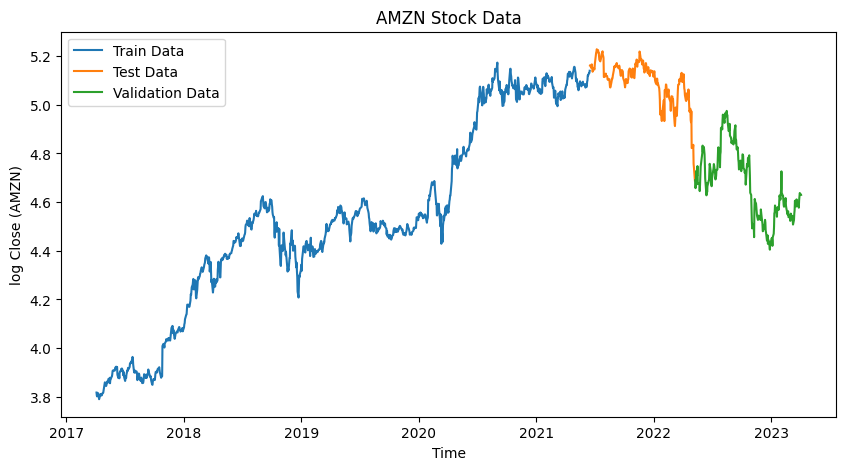

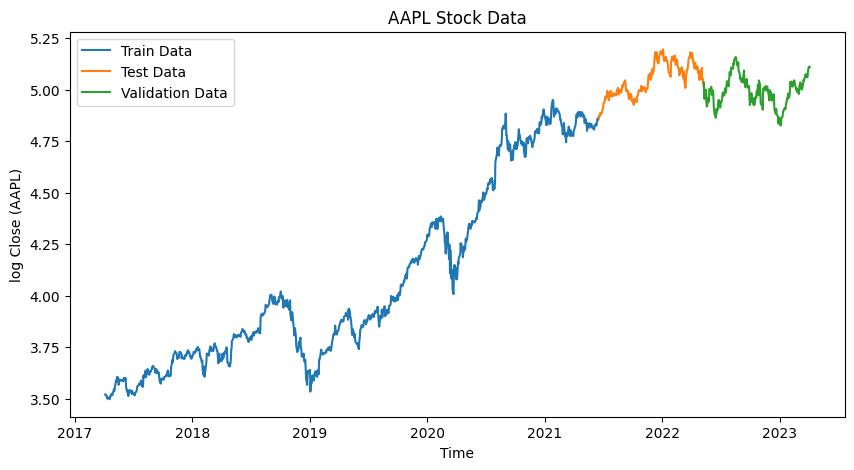

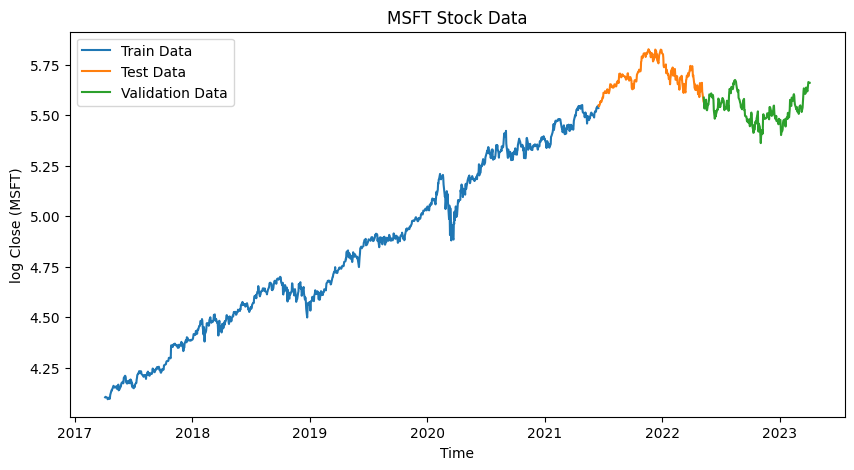

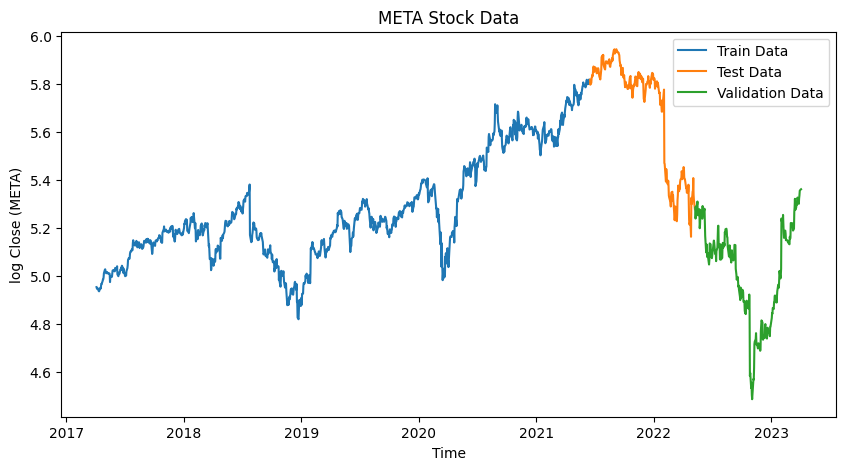

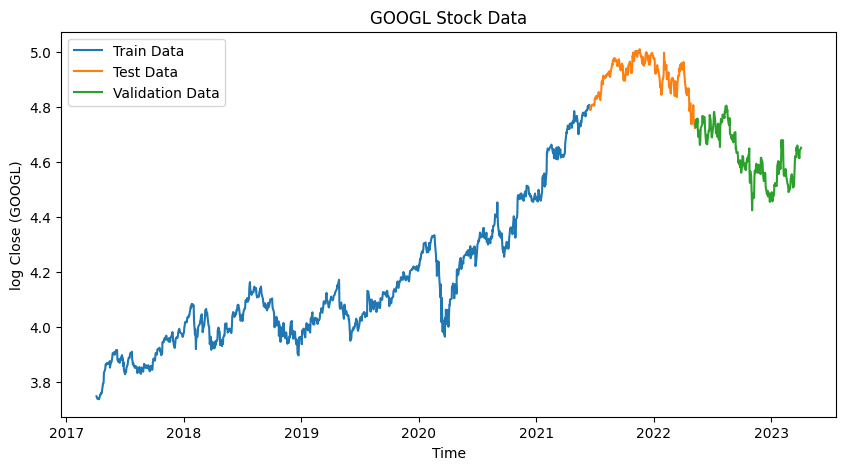

In [62]:
train_ratio = 0.7
test_ratio = 0.15
validation_ratio = 0.15

train_data = {}
test_data = {}
validation_data = {}

for ticker in tickers:
    stock_data = data[ticker]['Close'].apply(np.log)
    stock_size = len(stock_data)
    
    train_end = int(train_ratio * stock_size)
    test_end = int((train_ratio + test_ratio) * stock_size)

    train_data[ticker] = stock_data.iloc[:train_end]
    test_data[ticker] = stock_data.iloc[train_end:test_end]
    validation_data[ticker] = stock_data.iloc[test_end:]

for ticker in tickers:
    plt.figure(figsize=(10, 5))
    plt.plot(train_data[ticker].index, train_data[ticker], label='Train Data')
    plt.plot(test_data[ticker].index, test_data[ticker], label='Test Data')
    plt.plot(validation_data[ticker].index, validation_data[ticker], label='Validation Data')
    plt.xlabel('Time')
    plt.ylabel(f'log Close ({ticker})')
    plt.legend(loc='best')
    plt.title(f'{ticker} Stock Data')
    plt.show()
 


In [63]:
from pmdarima import auto_arima

auto_arima_models = {}

for ticker in tickers:
    auto_arima_model = auto_arima(train_data[ticker], seasonal=False, error_action='ignore', suppress_warnings=True)
    auto_arima_models[ticker] = auto_arima_model
    print(f'{ticker} Stock Auto ARIMA Model:')
    print(auto_arima_model.summary())
    print('\n' + '-'*100 + '\n')


AMZN Stock Auto ARIMA Model:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1057
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2674.587
Date:                Tue, 04 Apr 2023   AIC                          -5343.174
Time:                        14:45:36   BIC                          -5328.287
Sample:                             0   HQIC                         -5337.531
                               - 1057                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0013      0.001      2.240      0.025       0.000       0.002
ar.L1         -0.0625      0.021     -2.939      0.003      -0.104      -0.021
sigma2         0.0004  

In [64]:
from statsmodels.tsa.arima.model import ARIMA

arima_models = {}

for ticker in tickers:
    model = ARIMA(train_data[ticker], order=(5, 2, 2))
    arima_models[ticker] = model.fit()

for ticker in tickers:
    print(f"{ticker} ARIMA Model Summary:")
    print(arima_models[ticker].summary())
    print("\n")


AMZN ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1057
Model:                 ARIMA(5, 2, 2)   Log Likelihood                2667.455
Date:                Tue, 04 Apr 2023   AIC                          -5318.910
Time:                        14:45:44   BIC                          -5279.219
Sample:                             0   HQIC                         -5303.864
                               - 1057                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9472      0.108     -8.763      0.000      -1.159      -0.735
ar.L2         -0.0462      0.036     -1.294      0.196      -0.116       0.024
ar.L3          0.0165     

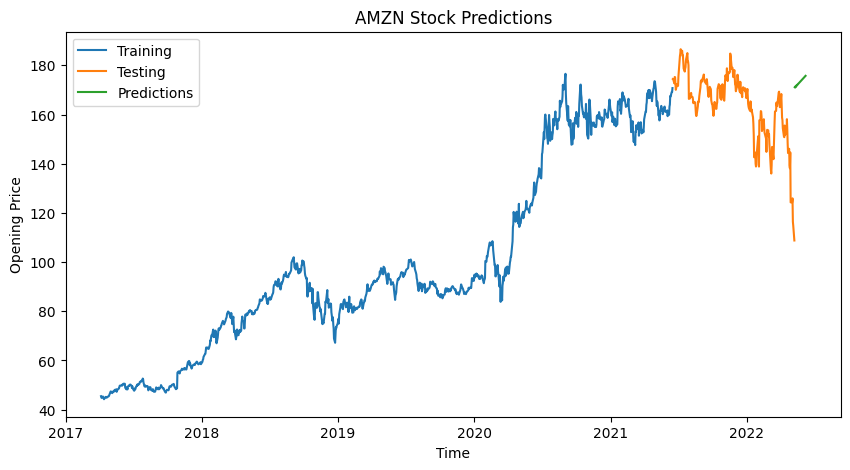

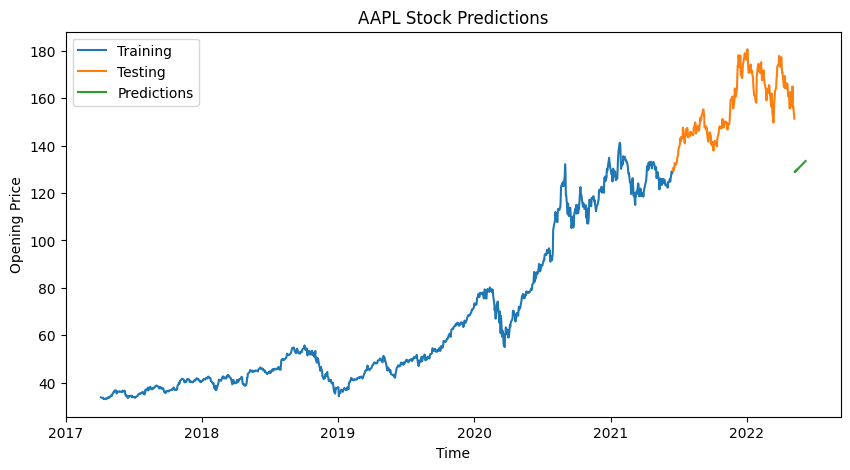

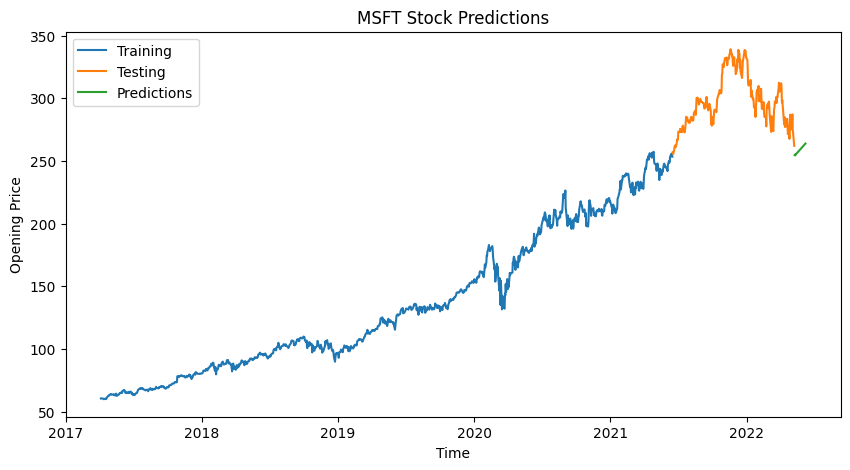

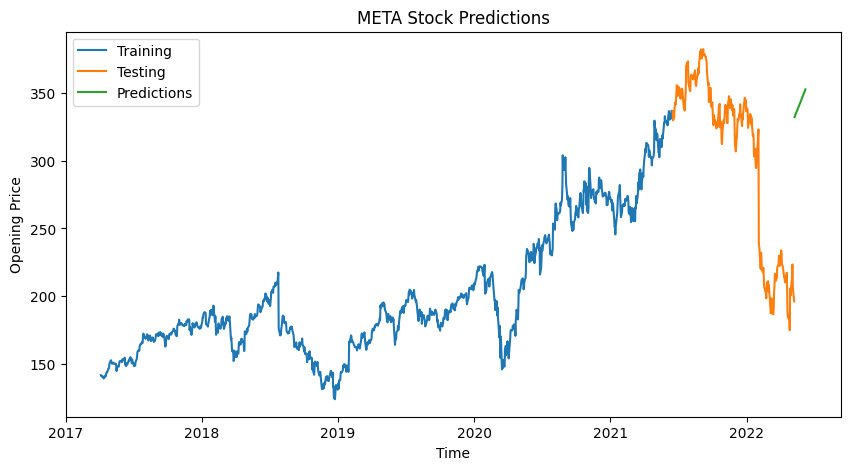

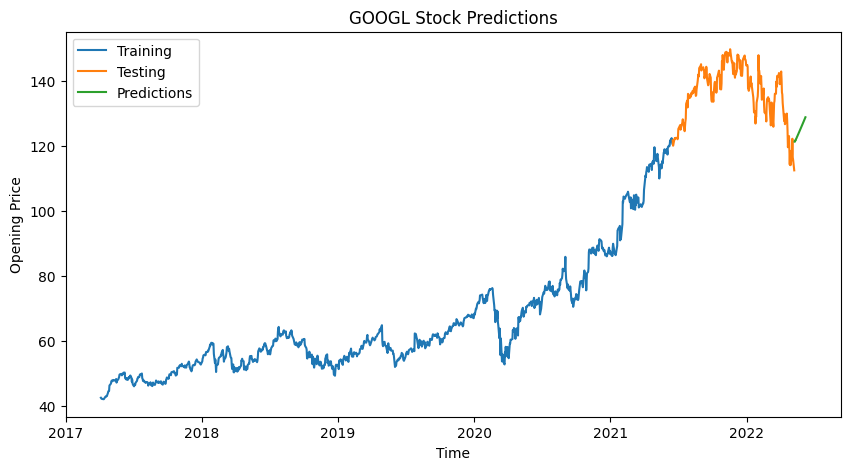

In [66]:
import matplotlib.pyplot as plt

forecast_steps = 30

for ticker in tickers:
    forecast_output = arima_models[ticker].forecast(forecast_steps)
    predictions = np.exp(forecast_output)
 
    plt.figure(figsize=(10, 5))
    plt.plot(train_data[ticker].index, np.exp(train_data[ticker]), label='Training')
    plt.plot(test_data[ticker].index, np.exp(test_data[ticker]), label='Testing')
    
    # Create a new index for the predictions starting from the end of the test_data index
    prediction_index = pd.date_range(start=test_data[ticker].index[-1], periods=forecast_steps + 1, closed='right')
    plt.plot(prediction_index, predictions, label='Predictions')
    plt.xlabel('Time')
    plt.ylabel('Opening Price')
    plt.legend()
    plt.title(f'{ticker} Stock Predictions')
    plt.show()
    
 